# AR(2) Signal with Additive White Noise

Here we import nessessary packages 

In [88]:
using Polynomials
using DSP
using Plots
pyplot()

include("wiener_filter_scalar.jl")
include("wiener_filter_scalar_fft.jl")

include("../../Model_Reduction_Dev.jl")

vector_wiener_filter_fft

The parameters for this model are defined here.

In [89]:
# r, t = rand(), 100*rand()

# each need modulus less than one for the process to be stationary. 
# Also for the process to be real-valued r1 and r2 are either real 
# or complex conjugates
r1, r2  = .99,-.5 #2*rand(2) .- 1 #r*exp(2*pi*im*t), r*exp(-2*pi*im*t) 
sig_v = 4
M_h = 50

50

## A Theoretical Solution

All the details for he formulation of `h_ana` are given in the Wiener Filtering Tutorial.

In [90]:
poly = complex(ones(5))

poly[1] = (r1*r2)/conj(r1*r2);
poly[2] = -(r1 + r2 + r1*r2*conj(r1+r2))/conj(r1*r2);
poly[3] = (sig_v^(-2) + 1 + abs(r1 + r2)^2 + abs(r1*r2)^2)/conj(r1*r2);
poly[4] = -(r1 + r2)/conj(r1*r2) - (r1+r2);
poly[5] = 1;
poly

rho_poly = Polynomial(poly)

rhos = roots(rho_poly)

rho1, rho2 = rhos[ abs.(rhos) .< 1]

phi0 = conj(rho1*rho2/r1/r2)/(sig_v)^2;

alpha(n) = sum([rho1^(n-k)*rho2^k for k = 0:n]);
beta(n) = sum([r1^(n-k)*r2^k for k = 0:n]);

M_gam = 1000 + M_h;

A = alpha.(0:M_gam);
B = beta.(0:M_gam);

gamma(n) = sum([conj(A[k])*B[k+n] for k = 1:1000]);

G = gamma.(0:M_h);

F = phi0*conv(G,A[1:M_h+1]);

h_ana = [F[1], F[2] - F[1]*(r1+r2)];

h_temp = [F[n] - (r1 + r2)*F[n-1] + r1*r2*F[n-2] for n = 3 : M_h];

h_ana = [h_ana; h_temp];

## Data and Numerical Solution

In [91]:
l = [1, -(r1 + r2), r1*r2];

Here we generate the data

In [ ]:
steps = 1*10^7
discard = 10^4
steps_tot = steps + discard

noise_sig = randn(steps_tot)
sig = zeros(steps_tot);

sig[1:2] = noise_sig[1:2];
for i = 3 : steps_tot
    sig[i] = dot(-reverse(l)[1:2],sig[i - 2:i-1]) + noise_sig[i]
end
sig = sig[discard + 1 : steps_tot];

noise_pred = sig_v*randn(steps)
pred = sig .+ noise_pred;

In [109]:
τ_exp, τ_int = auto_times(sig)

2-element Array{Float64,1}:
 100.2251656943783
 100.06480971343977

In [110]:
N_eff = steps/τ_int

99935.23226234541

Now we call the program I wrote to Numerically solve the Weiner filter. 

In [93]:
h_num = wiener_filter_Nu(pred,sig, par=150);
h_num_fft = wiener_filter_fft(pred, sig, par = 150);

Here I test the newwer version of the WF code.

In [118]:
sig_vec = reshape(sig,1,:)
pred_vec = reshape(pred,1,:)

h_num_mat = vector_wiener_filter_fft(
    sig_vec,
    pred_vec,
    M_h;
    par = 2000,
    win = "Par",
    n = 3,
    p = 1500,
    PI = true,
    rtol = 1e-6
    )

h_num = real(reshape(h_num_mat,:));

Now to verify the preformance.

error_num = 2.570395960500351
error_ana = 2.5703392391828594

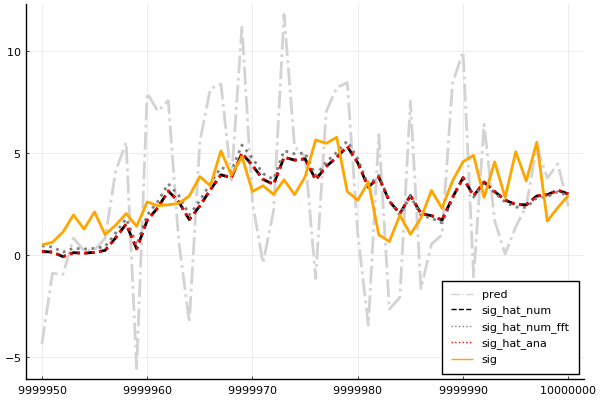

In [119]:
sig_hat_num_fft = conv(real.(h_num_fft),pred)[1:steps]
sig_hat_num = conv(real.(h_num),pred)[1:steps]
sig_hat_ana = conv(real.(h_ana),pred)[1:steps]

view = 50
start = steps - view
tim = start:start + view;
error_num = sum((sig .- sig_hat_num).^2)/steps;
error_ana = sum((sig .- sig_hat_ana).^2)/steps;

print("error_num = ",error_num,"\n")
print("error_ana = ",error_ana)

plot(tim,[pred[tim] sig_hat_num[tim] sig_hat_num_fft[tim] sig_hat_ana[tim] sig[tim]],
    color=[:lightgrey :black :gray :red :orange ], 
    line=(2,[:dashdot :dash :dot :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

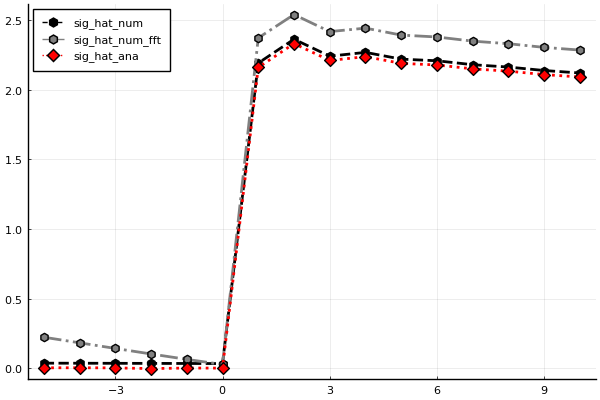

In [120]:
error_num_fft = sig .-sig_hat_num_fft
error_num = sig .-sig_hat_num
error_ana = sig .-sig_hat_ana
lags = -5:10
C_ana = crosscov(error_ana,pred,lags)
C_num = crosscov(error_num,pred,lags)
C_num_fft = crosscov(error_num_fft,pred,lags)
plot(lags, [C_num C_num_fft C_ana],
    color=[:black :grey :red],
    line=(2,[:dash :dashdot :dot]),
    label=["sig_hat_num" "sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :hex :d],6))

In [121]:
lags = -Nex:0
C_ana = crosscov(error_ana,pred,lags)
C_num = crosscov(error_num,pred,lags)
C_num_fft = crosscov(error_num_fft,pred,lags)

print(mean_and_var(C_num),'\n')
print(mean_and_var(C_num_fft),'\n')
print(mean_and_var(C_ana))

(0.007092824419000715, 0.000137487972046915)
(0.12091386305507248, 0.048274199441059464)
(0.002528668442271571, 2.989324007301511e-5)

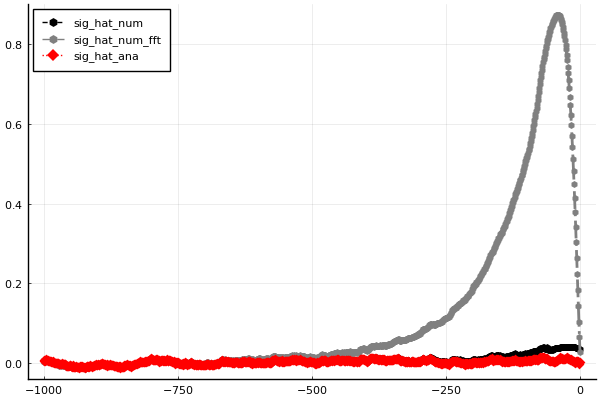

In [122]:
plot(lags, [C_num C_num_fft C_ana],
    color=[:black :grey :red],
    line=(2,[:dash :dashdot :dot]),
    markerstrokewidth = 0,
    label=["sig_hat_num" "sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :hex :d],5))

(0.12091386305507248, 0.048274199441059464)
(0.002528668442271571, 2.989324007301511e-5)

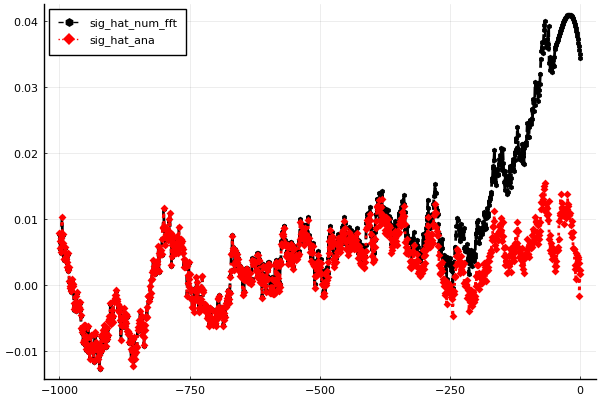

In [123]:
lags = -Nex:0
C_ana = crosscov(error_ana,pred,lags)
C_num_fft = crosscov(error_num_fft,pred,lags)
C_num = crosscov(error_num,pred,lags)

print(mean_and_var(C_num_fft),'\n')
print(mean_and_var(C_ana))

plot(lags, [C_num C_ana],
    color=[:black :red],
    line=(2,[:dash :dot]),
    markerstrokewidth = 0,
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],4))

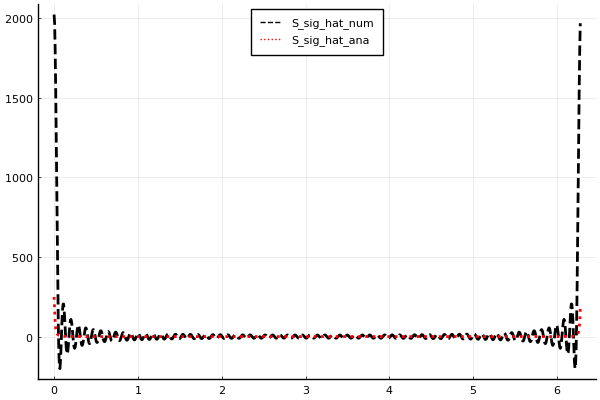

In [124]:
Nex = 1000;
Theta = 2*pi*(0:Nex - 1)/Nex
Z = exp.(im*Theta);

S_sig_hat_num = z_crossspect(sig_hat_num,sig_hat_num,70; win = "Bart")

H(z) = sum([h_ana[i+1]*z^(-i) for i = 0 : M_h-1]);
S_pred(z) = (conj(r1*r2)*rho_poly(z)/z^2)/((1-r1*z^(-1))*(1-r2*z^(-1))*(1-conj(r1)*z)*(1-conj(r2)*z));
S_sig_hat_ana(z) = H(z)*S_pred(z)*conj(H(conj(z)^(-1)));

plot(Theta,[real.(S_sig_hat_num.(Z)) real.(S_sig_hat_ana.(Z))],
    color=[:black :red],line=(2,[:dash :dot]),label=["S_sig_hat_num" "S_sig_hat_ana"])